In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import interp
from numpy import random
import sys
sys.path.append("/home/mizworski/Repos/xgboost/python-package/")
# sys.path.append("/home/mizworski/Repos/LightGBM/python-package/")
sys.path.append("..")

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.utils.validation import column_or_1d
import matplotlib.pyplot as plt
# https://github.com/Microsoft/LightGBM
import lightgbm as lgb

In [2]:
df = pd.read_csv('../data/bank-classification.csv', index_col=0)
df = df.sample(frac=1)
df.head()

,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,
40648,1985-01-20,admin.,single,university.degree,no,yes,no,2010-09-14,cellular,1,999,1,failure,unknown
4682,1973-06-26,blue-collar,married,basic.9y,no,yes,no,2008-05-14,telephone,1,999,0,nonexistent,no
16051,1981-03-29,admin.,single,university.degree,unknown,yes,yes,2008-07-01,cellular,1,999,0,nonexistent,unknown
27136,1968-08-19,management,married,university.degree,no,yes,no,2008-11-28,cellular,1,999,0,nonexistent,no
14628,1961-08-23,blue-collar,married,basic.9y,no,no,no,2008-07-22,cellular,2,999,0,nonexistent,no


In [3]:
date_parse_format = '%Y-%m-%d'

def preprocess_data(data):
    now = datetime.strptime(data.contact_date.max(), date_parse_format)
    data['sum_nan'] = (data[['default', 'loan', 'education', 'housing', 'job']] == 'unknown').sum(axis=1)
    data['age'] = data.apply(lambda r: int((now - datetime.strptime(r.birth_date, date_parse_format)).days / 365.25), axis=1)
    data.drop('birth_date', axis=1, inplace=True)
    
    categorical_cols = list(set(data.columns) - set(['birth_date', 'contact_date', 'pdays', 'campaign', 'y','age', 'sum_nan']))
    X = pd.get_dummies(data, columns=categorical_cols)
    X['contacted'] = pd.get_dummies(X.pdays < 999, drop_first=True)
    
    X['days_since_contact'] =  X.apply(lambda r: int((now - datetime.strptime(r.contact_date, date_parse_format)).days), axis=1)
    
    X.drop('contact_date', axis=1, inplace=True)
    
    train_x = X[X.y != 'unknown']
    test_x = X[X.y == 'unknown']
    train_y = train_x['y']
    train_y = pd.get_dummies(train_y, drop_first=True)
    train_x = train_x.drop('y', axis=1)
    test_x = test_x.drop('y', axis=1)
    
    return train_x, train_y, test_x
    

In [4]:
X_train, Y_train, X_test = preprocess_data(df.copy())

In [5]:
X_train['houseXmarried'] = X_train.housing_yes * X_train.marital_married
X_train['uniXmarried'] = X_train['education_university.degree'] * X_train.marital_married
X_train['highschoolXmarried'] = X_train['education_high.school'] * X_train.marital_married
X_train['job_high_paid'] = X_train.job_entrepreneur + X_train.job_management + X_train.job_technician
X_train['campaignXdays_since_contact']= X_train.campaign * X_train.days_since_contact
X_train['campaignXpoutcome_success']= X_train.campaign * X_train.poutcome_success

X_test['houseXmarried'] = X_test.housing_yes * X_test.marital_married
X_test['uniXmarried'] = X_test['education_university.degree'] * X_test.marital_married
X_test['highschoolXmarried'] = X_test['education_high.school'] * X_test.marital_married
X_test['job_high_paid'] = X_test.job_entrepreneur + X_test.job_management + X_test.job_technician
X_test['campaignXdays_since_contact']= X_test.campaign * X_test.days_since_contact
X_test['campaignXpoutcome_success']= X_test.campaign * X_test.poutcome_success

In [6]:
X_train.columns

Index(['campaign', 'pdays', 'sum_nan', 'age', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'marital_divorced',
       'marital_married', 'marital_single', 'marital_unknown', 'housing_no',
       'housing_unknown', 'housing_yes', 'default_no', 'default_unknown',
       'default_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success',
       'contact_cellular', 'contact_telephone', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'previous_0', 'previous_1', 'previous_2', 'previous_3', 'previous_4',
       'previous_5', 'previous_6', 'previous_7', 'contacted',
       'days_sin

In [7]:
X_train.head()

,campaign,pdays,sum_nan,age,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,...,previous_6,previous_7,contacted,days_since_contact,houseXmarried,uniXmarried,highschoolXmarried,job_high_paid,campaignXdays_since_contact,campaignXpoutcome_success
id,,,,,,,,,,,,,,,,,,,,,
4682,1,999,0,37,0,0,1,0,0,0,...,0,0,0,930,1,0,0,0,930,0
27136,1,999,0,42,0,0,0,0,0,0,...,0,0,0,732,1,1,0,1,732,0
14628,2,999,0,49,0,0,1,0,0,0,...,0,0,0,861,0,0,0,0,1722,0
4493,2,999,0,35,0,0,0,0,0,1,...,0,0,0,931,0,0,0,1,1862,0
9750,3,999,0,37,0,0,1,0,0,0,...,0,0,0,883,0,0,0,0,2649,0


In [8]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import  LogisticRegression, LinearRegression
from sklearn.ensemble import VotingClassifier

In [9]:
def get_ensemble():
    model1 = [XGBClassifier(max_depth=4, gamma=3, reg_alpha=0.2137, min_child_weight=2, n_estimators=800,
                            reg_lambda=1, subsample=1, max_delta_step=5, learning_rate=0.01) for i in range(3)]

    model2 = [lgb.LGBMClassifier(colsample_bytree= 0.9, learning_rate=0.03,
                                 boosting_type= 'dart',subsample= 0.75,
                                 num_boosting_rounds=256, metric='auc',
                                 n_estimators=400, reg_lambda=0, reg_alpha=0, num_leaves=16
                                 ) for i in range(3)]

    eclf = VotingClassifier(estimators=[
        ('xgb0', model1[0]),('xgb1', model1[1]),
        ('lgbm0', model2[0]), ('lgbm1', model2[1]), ('lgbm2', model2[2]), 
                                       ], voting='soft')
    return eclf

In [10]:
cv = StratifiedKFold(n_splits=5)

X = X_train.as_matrix()
Y = column_or_1d(Y_train)

i=0 auc=0.77750680891249
i=1 auc=0.8021583226124326
i=2 auc=0.7999730836960192
i=3 auc=0.7733881011688063
i=4 auc=0.8006751438017509


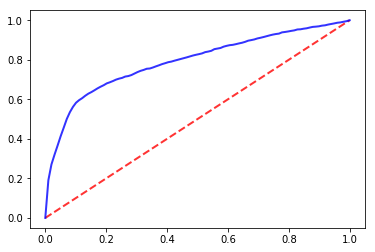

In [11]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i=0

for train, test in cv.split(X, Y):
    ensemble = get_ensemble()
    
    probas_ = ensemble.fit(X[train], Y[train]).predict_proba(X[test])
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    print('i={} auc={}'.format(i, roc_auc))
    aucs.append(roc_auc)

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.show()

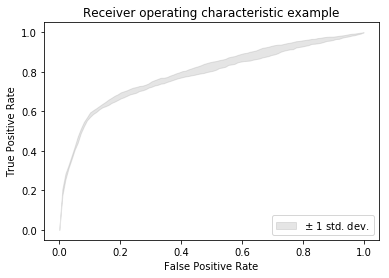

0.79040764147716025

In [12]:
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

mean_auc

In [13]:
ensemble = get_ensemble()
test_probs = ensemble.fit(X, Y).predict_proba(X_test.as_matrix())[:,1]

test_indices = X_test.index.values
results = pd.DataFrame({'id':test_indices, 'y':test_probs})
results_sorted = results.sort_values(['id'])
results_sorted.to_csv('ensemble_res.csv', index=False)